In [1]:
import gymnasium as gym
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm, trange
from cryoenv.mqtt import SoftActorCritic, ReturnTracker, HistoryWriter, CryoWorldModel, generate_sweep, augment_pars, double_tes
%config InlineBackend.figure_formats = ['png']

In [2]:
torch.cuda.is_available()

False

In [3]:
warnings.simplefilter('ignore')
gym.logger.set_level(40)

In [4]:
name_load = 'li1p'
version = '4'
rseed = int(version)
buffer_save_path = 'buffers_inf/'
buffer_size = 5200


In [5]:
with open("saved_pars/{}_pars_cryoenv.pkl".format(name_load),"rb") as fh:
    pars_load = pickle.load(fh)

In [6]:
tries = 0

while True:
    
    if tries > 10:
        raise AssertionError

    add_pars = {
        'store_raw': True,
        'max_buffer_len': buffer_size,
        'tpa_queue': [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'pileup_prob': 0.,
        'tp_interval': 10,
        'dac_range': (0., 5.), 
        'Ib_range': (0.5, 5.), 
        'adc_range': (-10., 10.),
        'rseed': rseed,
        'tau_cap': np.array([1.]),
                }

    np.random.seed(rseed)

    # pars_load = double_tes(pars_load)

    aug_pars = augment_pars(pars_load, **add_pars)
    # aug_pars = {**pars_load, **add_pars}

    env = gym.make('cryoenv:cryoenv-sig-v0',
                       omega=0.,
                       log_reward=False,
                       rand_start=True,
                       relax_time=60,
                       tpa_in_state=True,
                       div_adc_by_bias=True,
                       pars=aug_pars,
                       render_mode='plotly',
                       rand_tpa=False,
                       )

    # check if transition is reachable

    env.detector.set_control(dac=np.ones(env.nheater), Ib=np.ones(env.ntes), norm=True)

    for i in range(10):
        env.detector.wait(5)

    try:
        for i in range(env.ntes):  # assumes TES are the first components!
            assert env.detector.Rt[i](env.detector.T[0,i]) > env.detector.Rs[i], 'transition of TES {} not reachable'.format(i)
        print('All transistions reachable, continuing')
        break
    except AssertionError:
        rseed *= 1000
        tries += 1
        print('Resampling parameters, new rseed: {}'.format(rseed))

All transistions reachable, continuing


# manual control

In [163]:
env.detector.set_control(dac=np.array([-.3]), Ib=np.array([1.]), norm=True)

In [187]:
env.detector.wait(100.)

In [188]:
env.detector.trigger(er=np.array([0., 2.]), tpa=np.array([0.]))

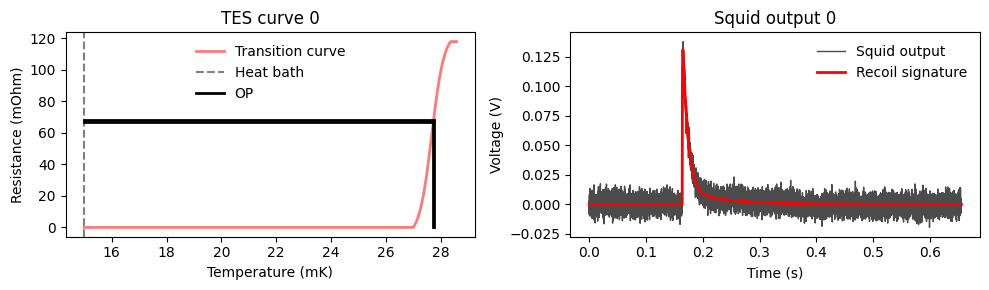

In [189]:
env.detector.plot_tes()

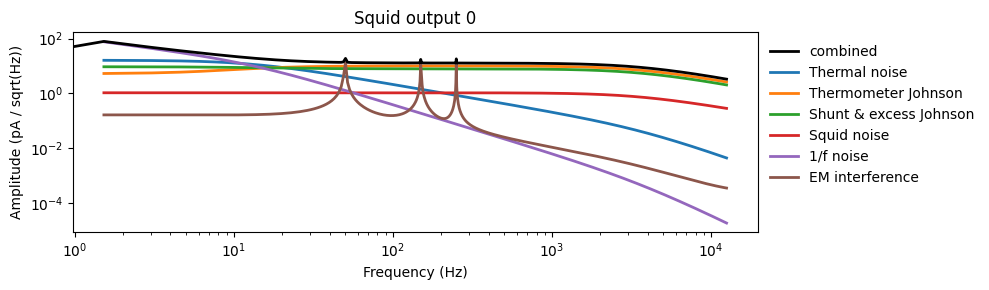

In [190]:
env.detector.plot_nps()

In [186]:
trace_cp = np.copy(env.detector.squid_out_noise)

In [191]:
trace_tp = np.copy(env.detector.squid_out_noise)

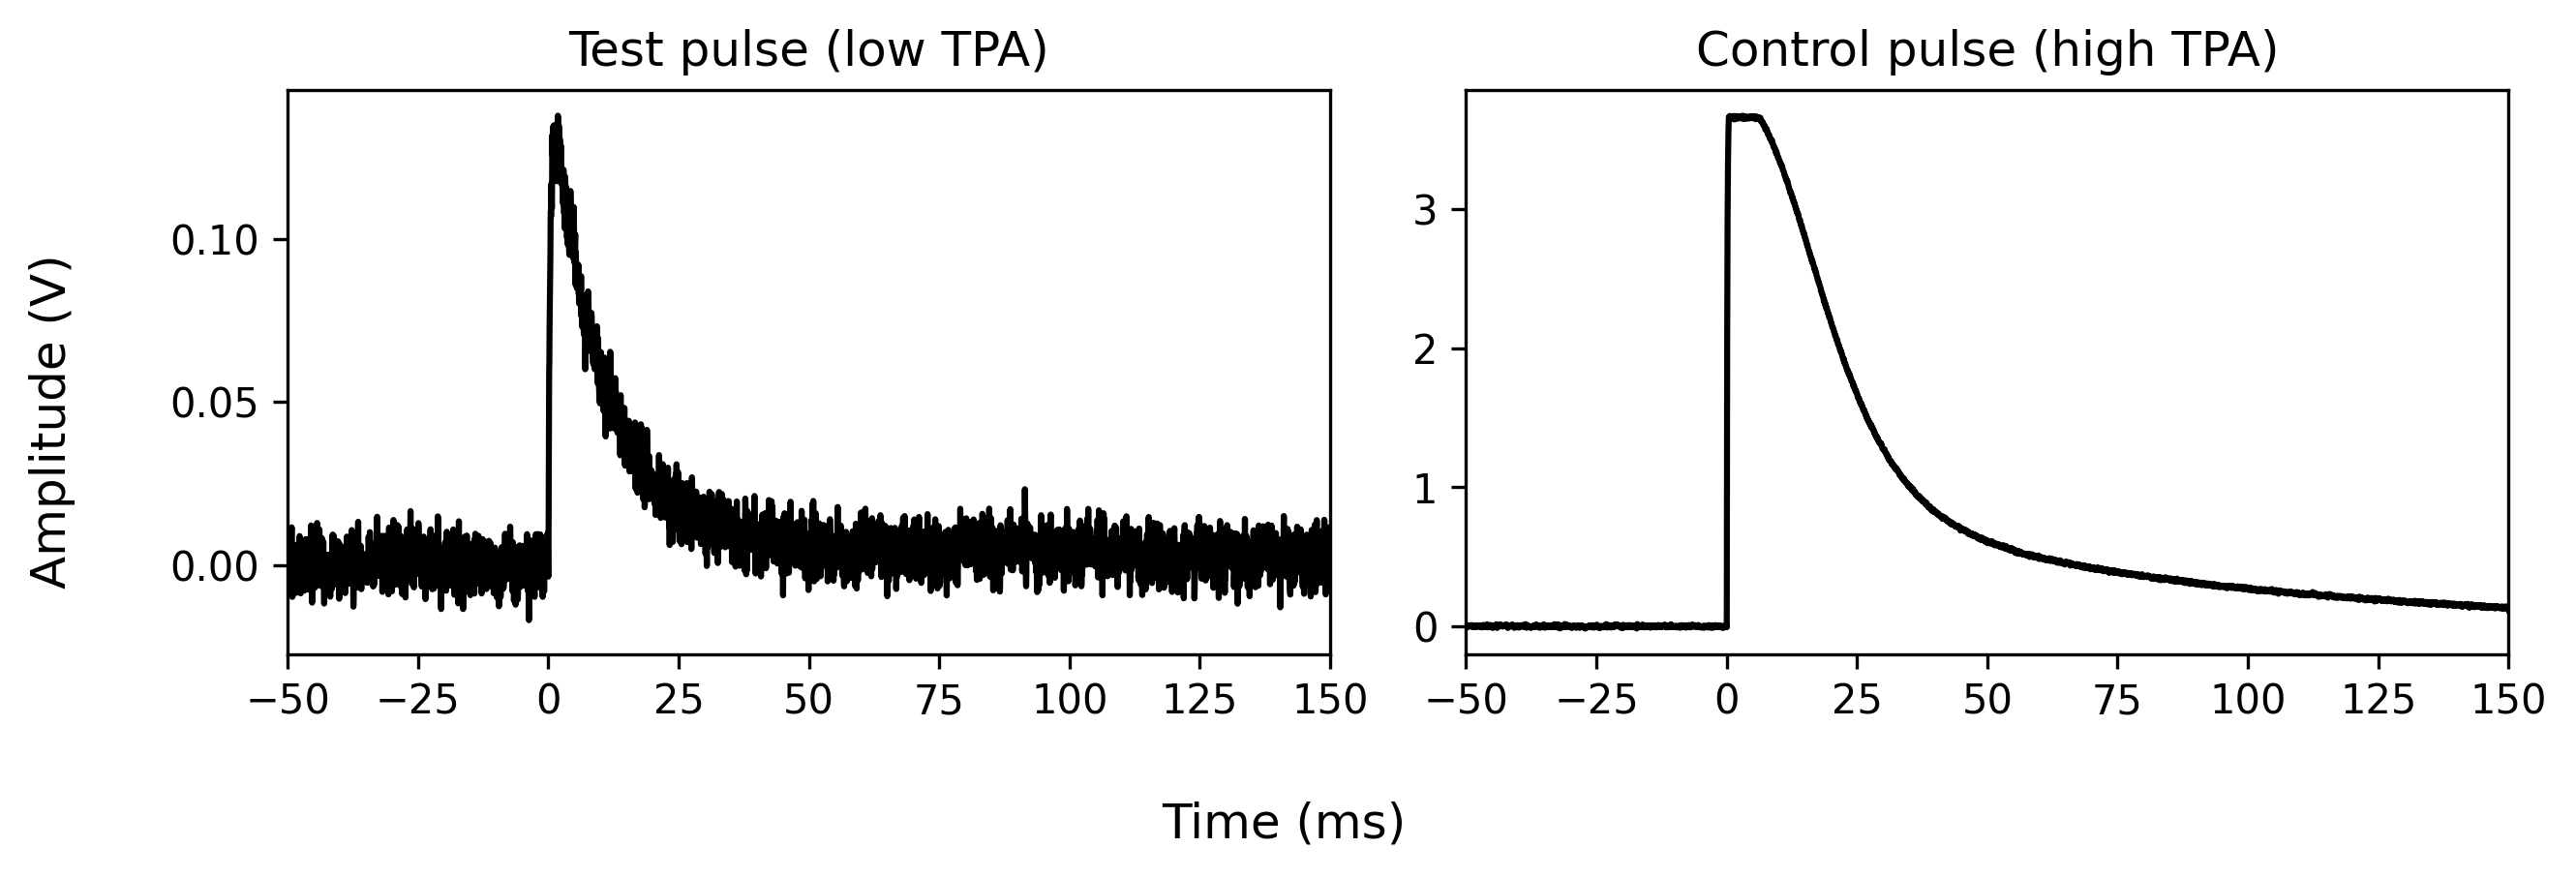

In [219]:
fig, axes = plt.subplots(1,2, figsize=(9,3), dpi=300)

time = (env.detector.t - env.detector.t[-1]/4)*1000

axes[0].plot(time, trace_tp, color='black')
axes[1].plot(time, trace_cp, color='black')
# axes[0].axis('off')
# axes[1].axis('off')
axes[0].set_title('Test pulse (low TPA)')
axes[1].set_title('Control pulse (high TPA)')
axes[0].set_xlim(-50,150)
axes[1].set_xlim(-50,150)
fig.supxlabel('Time (ms)')
fig.supylabel('Amplitude (V)')
plt.tight_layout()
plt.savefig('plots_paper/test_control_pulses.png')
plt.show()

# training

In [7]:
obs, info = env.reset()

In [8]:
env.state  # PH, RMS, DAC, IB, TPA, CPE

array([-0.99967157, -0.99993691, -0.44627655,  0.51169682, -0.6       ,
       -0.9997629 ])

In [9]:
# worked for bs = 8, grs = 5 after 16 60 step EPs, without sweep
# worked for bs = 16, grs = 20 after ~10 60 step EPs, without sweep
# higher noise, higher omega, already after 6 EPs

model = SoftActorCritic(env, policy = "GaussianPolicy", critic = "QNetwork", lr=3e-4, buffer_size=buffer_size, learning_starts=0,
                        batch_size=16, gamma=.99, gradient_steps=25, grad_clipping=.5, tau=0.005, 
                        device='cuda' if torch.cuda.is_available() else 'cpu',
                        target_entropy_reduction=.9999,
                       )

In [10]:
tracker = ReturnTracker()
writer = HistoryWriter()

In [11]:
env.launch_display(title='Training {} with {} TES'.format(name_load, env.ntes), 
                   color='red' if name_load == 'li1p' else 'turquoise' if name_load == 'li1l' else 'yellow' if name_load == 'li2p' else None)

FigureWidget({
    'data': [{'marker': {'color': 'red'},
              'mode': 'lines',
              'name': 'Pulse TES 0',
              'type': 'scatter',
              'uid': '588f9770-548c-4a78-88cc-a60b924ddf7c',
              'xaxis': 'x',
              'y': [0.0],
              'yaxis': 'y'},
             {'marker': {'color': 'red'},
              'mode': 'lines',
              'name': 'PH TES 0',
              'type': 'scatter',
              'uid': '29a46899-cc0a-4416-8929-21334eccdef1',
              'xaxis': 'x2',
              'y': [0.0],
              'yaxis': 'y2'},
             {'marker': {'color': 'red'},
              'mode': 'lines',
              'name': 'DAC TES 0',
              'type': 'scatter',
              'uid': '17c723f2-5476-4428-8c5a-58b665311c76',
              'xaxis': 'x3',
              'y': [0.0],
              'yaxis': 'y3'},
             {'marker': {'color': 'red'},
              'mode': 'lines',
              'name': 'IB TES 0',
              'typ

In [12]:
# force the sweep

ops = generate_sweep(12,10)

state = obs

for dac,ib in tqdm(ops):
    action = [dac] * env.nheater
    action.extend([ib] * env.ntes)
    action = np.array(action)
    next_state, reward, terminated, truncated, info = model.env.step(action)
    model.buffer.store_transition(state, action, reward, next_state, terminated)
    state = next_state

  0%|          | 0/120 [00:00<?, ?it/s]

In [13]:
model.learn(episodes = 40, 
            episode_steps = 60, 
            two_pbars=True,
            tracker=tracker,
            writer=writer)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
# save buffer

import os 

path_models = '{}{}_v{}/models/'.format(buffer_save_path, name_load, version)
path_data = '{}{}_v{}/data/'.format(buffer_save_path, name_load, version)

os.mkdir(path_models[:-8])
os.mkdir(path_models[:-1])
os.mkdir(path_data[:-1])


In [14]:
all_buffers = ['state_memory', 'next_state_memory', 'action_memory', 'reward_memory', 'terminal_memory', 'buffer_counter', 'buffer_total']
if hasattr(model.buffer, 'trajectory_idx'):
    all_buffers.append('trajectory_idx')

for name_buffer in all_buffers:
    np.save(path_data + name_buffer + '.npy', eval('model.buffer.{}'.format(name_buffer)))

In [15]:
model.save(path_models)

In [16]:
import json
  
with open('{}{}_v{}/info.txt'.format(buffer_save_path, name_load, version), 'w') as fh:
    for key, value in aug_pars.items(): 
        fh.write("'{}': {}\n".format(key, value))

# buffer

In [17]:
# world_model.get_reward()

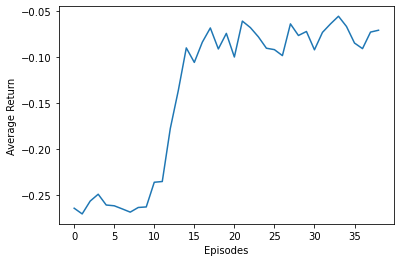

In [18]:
tracker.plot(smooth=1)

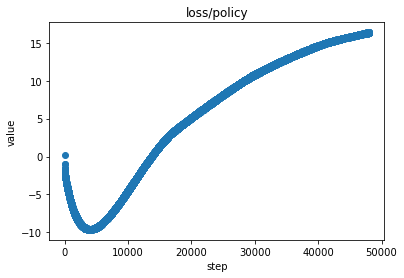

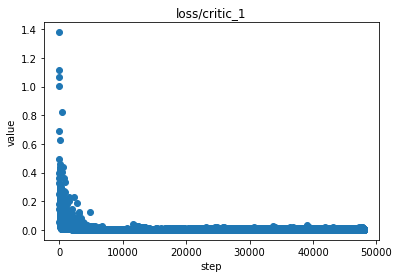

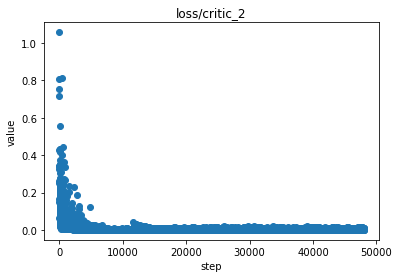

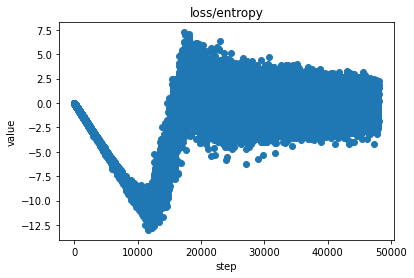

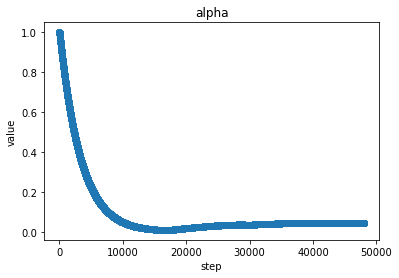

In [19]:
for key in writer.history.keys():
    writer.plot(key)

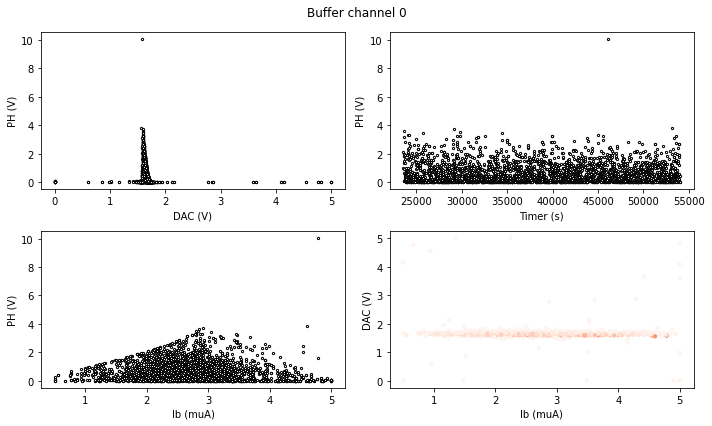

In [20]:
for i in range(env.ntes):
    env.detector.plot_buffer(tes_channel=i)#, save_path=path_data + 'plot_buffer_{}.png'.format(i))

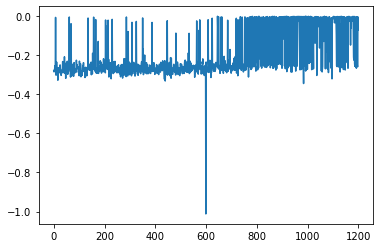

In [21]:
plt.plot(model.buffer.reward_memory[:1200])
# plt.ylim(-.01,0.001)

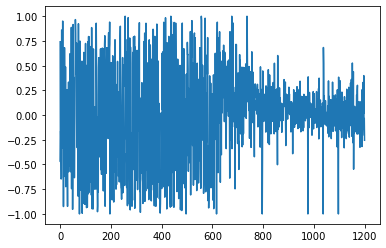

In [22]:
plt.plot(model.buffer.state_memory[:1200,2])

# inference

In [19]:
env.launch_display(title='Inference {} with {} TES'.format(name_load, env.ntes), 
                   color='red' if name_load == 'li1p' else 'turquoise' if name_load == 'li1l' else 'yellow' if name_load == 'li2p' else None)

FigureWidget({
    'data': [{'marker': {'color': 'red'},
              'mode': 'lines',
              'name': …

In [20]:
model = SoftActorCritic.load(env, path='buffers/{}_v{}/models/'.format(name_load, version), 
                             policy = "GaussianPolicy", critic = "QNetwork", load_critic=True, 
                             lr=3e-4, buffer_size=buffer_size, learning_starts=0,
                             batch_size=16, gamma=.99, gradient_steps=20, grad_clipping=.5, tau=0.005, 
                             device='cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
obs, _ = env.reset(clear_buffer=True)
model.policy.eval()
returns = 0
for i in trange(60):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action.flatten())
    # print(action)
    # print(obs, reward)
    returns += reward
    # env.render()
    if terminated or truncated:
        obs, _ = env.reset()

  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

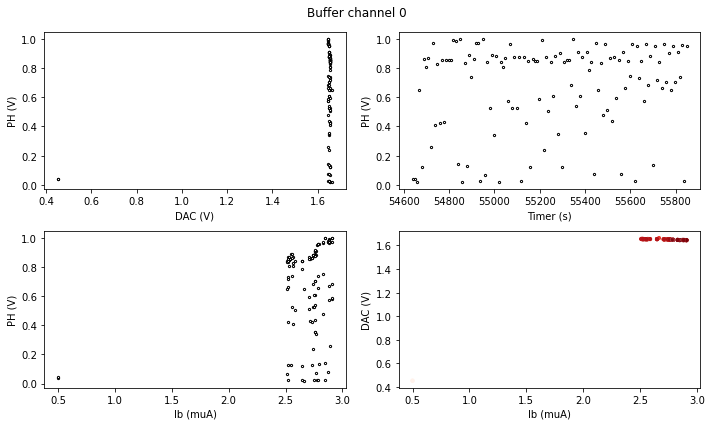

In [27]:
for i in range(env.ntes):
    env.detector.plot_buffer(tes_channel=i)

In [23]:
# env.close()

# analyze policy

In [32]:
policy = model.policy
target_critic = model.target_critic

x = model.buffer.state_memory

idx_current = 50
idx_max = 51
idx_min = 49

names = ['PH', 'RMS', 'IB', 'DAC', 'TPA', 'CPH']

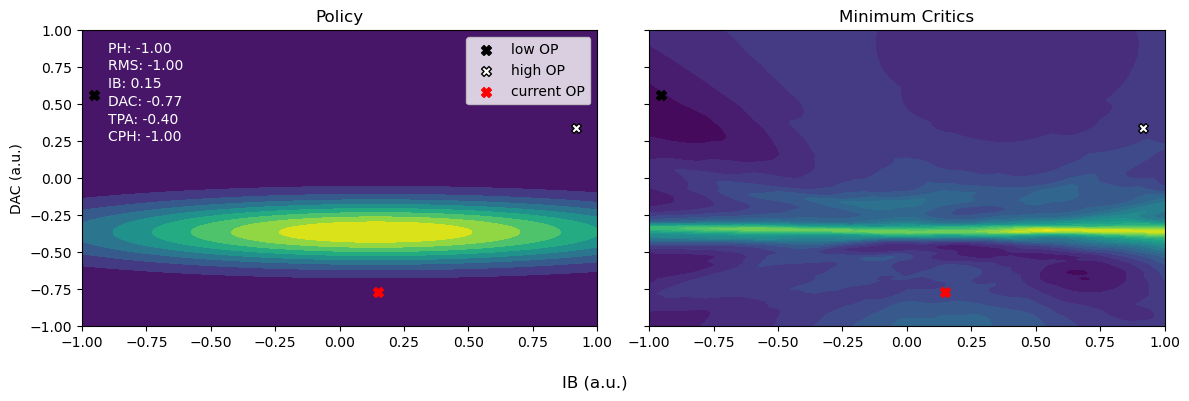

In [33]:
from scipy.stats import multivariate_normal

plot_scatter = True
min_critics = True 

obs = torch.tensor(x[idx_current], dtype=torch.float32).reshape(1, -1) 
# obs = torch.tensor([-1., -1., .369, -.38, .0]).reshape(1, -1)  # PH, RMS, IB, DAC, CPH
#obs[0,0] = -0.4
min_obs = torch.tensor(x[idx_min], dtype=torch.float32).reshape(1, -1) 
max_obs = torch.tensor(x[idx_max], dtype=torch.float32).reshape(1, -1) 

mu, log_std = policy(obs)
mu = mu.detach().numpy().flatten()
with torch.no_grad():
    log_std = log_std.numpy().flatten()

rv = multivariate_normal(mu, np.diag(np.exp(log_std)))

x_grid, y_grid = np.mgrid[-1:1.01:.01, -1:1.01:.01]
pos = np.dstack((x_grid, y_grid))


action = torch.tensor([[x_,y_] for x_,y_ in zip(x_grid.flatten(), y_grid.flatten())], dtype=torch.float32)  # , dtype=torch.float32

with torch.no_grad():
    val1, val2 = target_critic(torch.tile(obs, (40401,1)), action)
    val_min = torch.min(val1, val2)

fig, ax = plt.subplots(1,2 if min_critics else 3,dpi=100,figsize=(12,4), sharex=True, sharey=True)

ax[0].contourf(y_grid, x_grid, rv.pdf(pos), levels=10)  # IB, DAC
if plot_scatter:
    ax[0].scatter(min_obs[0,2], min_obs[0,3], color='black', edgecolor='black', s=100*(min_obs[0,0]+1) + 50, marker='X', label='low OP')
    ax[0].scatter(max_obs[0,2], max_obs[0,3], color='white', edgecolor='black', s=100*(max_obs[0,0]+1) + 50, marker='X', label='high OP')
    ax[0].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1) + 50, marker='X', label='current OP')
    ax[0].legend()

for i,n in enumerate(names):
    ax[0].text(-0.9, 0.85 - i*0.12, '{}: {:.2f}'.format(n, obs[0,i]), color='white')
ax[0].set_ylabel('DAC (a.u.)')
ax[0].set_title('Policy')
if not min_critics:
    ax[1].contourf(y_grid, x_grid, val1.reshape(201,201), levels=20)  # IB, DAC
    if plot_scatter:
        ax[1].scatter(min_obs[0,2], min_obs[0,3], color='black', edgecolor='black', s=100*(min_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(max_obs[0,2], max_obs[0,3], color='white', edgecolor='black', s=100*(max_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1) + 50, marker='X', label='current OP')
    ax[1].set_title('Critic 1')
    ax[2].contourf(y_grid, x_grid, val2.reshape(201,201), levels=20)  # IB, DAC
    if plot_scatter:
        ax[2].scatter(min_obs[0,2], min_obs[0,3], color='black', edgecolor='black', s=100*(min_obs[0,0]+1) + 50, marker='X')
        ax[2].scatter(max_obs[0,2], max_obs[0,3], color='white', edgecolor='black', s=100*(max_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1) + 50, marker='X', label='current OP')
    ax[2].set_title('Critic 2')
else:
    ax[1].contourf(y_grid, x_grid, val_min.reshape(201,201), levels=20)  # IB, DAC
    if plot_scatter:
        ax[1].scatter(min_obs[0,2], min_obs[0,3], color='black', edgecolor='black', s=100*(min_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(max_obs[0,2], max_obs[0,3], color='white', edgecolor='black', s=100*(max_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1) + 50, marker='X', label='current OP')
    ax[1].set_title('Minimum Critics')
    
plt.xlim(-1,1)
plt.ylim(-1,1)
fig.supxlabel('IB (a.u.)')
plt.tight_layout()
plt.show()